In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = r"D:\COEP\BTech_Project\Dataset\2043_combined"
WORKING_DIR = r"D:\COEP\BTech_Project\Code\new_dataset_code\VGG_RNN"

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/2043 [00:00<?, ?it/s]

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Creating mapping for images and captions

In [7]:
import os 

# load doc into memory
def read_text_file(filename):
#     text = f.read()
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")
#     Lines = file.readlines()
    text = file.read()
 
    # Strips the newline character
#     for line in Lines:
#         text = text + line.strip()
    # close the file
    file.close()
    text = 'startseq ' + text + ' endseq'
    return text

# Folder Path 
path = r"D:\COEP\BTech_Project\Dataset\2043_combined\text"
  
# Change the directory 
os.chdir(path) 
  
#Create dictionary mapping
mapping = {}
  
  # iterate through all file 
for file in os.listdir(): 
    # Check whether file is in text format or not 
    if file.endswith(".txt"): 
        file_path = f"{path}\{file}"
        baseFileName = os.path.splitext(file)[0]
        
        # call read text file function 
        caption = read_text_file(file_path)
        mapping[baseFileName] = caption
#         print(caption)

In [8]:
all_captions = []
maxi = '1'
for key in mapping:
    if(len(mapping[maxi].split()) < len(mapping[key].split())):
        maxi = key
#         print(maxi)
#     print(result)
    all_captions.append(mapping[key])

In [9]:
all_captions[0]

'startseq स्वासनिधी राजमान्य राजश्री माधवराव पंडित प्रधान तां मोकदम व रयान मौजे वाठार पाा फलटण सुा इसने सबैन मया व अलफ तु endseq'

In [10]:
# tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

12532


In [11]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

72

In [12]:
mapping['103']

'startseq जाब आला की बेलभाक घेऊन लेकास पाठवणे अथवा तुम्ही विचार पाहोन जावयाचे तरी जाणे यैसा जाब आला त्यावरी कान्होजी नाा पाचजण लेक बाा घेऊन राजश्री स्वामीच्या दरशनास सीवापटणास गेले भेटी जाली येकांती बैसोन बोलिले endseq'

In [13]:
image_ids = list(mapping.keys())
# np.random.shuffle(image_ids)

test = []
train = []
    
path = r"D:\COEP\BTech_Project\Dataset\Test_Images"
for file in os.listdir(path=path): 
    file_path = f"{path}\{file}"
    baseFileName = os.path.splitext(file)[0]
    test.append(baseFileName)

for img in image_ids:
    if(img not in test):
        train.append(img)
# split = int(len(image_ids) * 0.80)
# train = image_ids[:split]
# test = image_ids[split:]
print(len(train))
print(len(test))

1841
202


In [14]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            caption = mapping[key]
            # process each caption

            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]

            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                # store the sequences
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 print(X1.shape, X2.shape, y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [15]:
# encoder model
# image feature layers
import tensorflow as tf
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)
se3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,dropout=0.4))(se2)
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
# plot_model(model, show_shapes=True)

In [16]:
# train the model
epochs = 30
batch_size = 32
steps = len(train)//batch_size
test_steps = len(test)//batch_size

training_loss = []
test_loss = []

for i in range(epochs):
    # create data generator
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(train_generator, validation_data=test_generator, epochs=1, steps_per_epoch=steps, validation_steps=test_steps, verbose=1)
    training_loss.append(model.history.history['loss'])
    test_loss.append(model.history.history['val_loss'])

57/57 [==============================] - 230s 4s/step - loss: 4.5524 - val_loss: 15.4889


In [17]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

### LOAD SAVED MODEL AND FEATURES

In [ ]:
import tensorflow as tf
from tensorflow import keras

# load features from pickle
features = {}
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

new_model = tf.keras.models.load_model(r"D:\COEP\BTech_Project\Code\VGG_RNN\best_model.h5")

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [22]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    caption = mapping[image_id]
    print('---------------------Actual---------------------')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
print(test_loss)

---------------------Actual---------------------
startseq व्हा तुम्हाकडूनहि तैसेच घडावे सनदी जाबसालास कटकटीचे कारण नाही परंतु त्याची चाल आहें तीच आहे याजकरिता येविसी तुम्ही राजश्री पंतप्रधान यासी बोलून राा आपाजी रघुनाथ व हुजरे endseq
--------------------Predicted--------------------
startseq श्री परस्थळीं राजश्री मातुश्री नारो मातुश्री नारो पंतप्रधान सीतैन सु सीतैन सु इसने इसने इसने ईसने इसने इसने ईसने इसने इसने ईसने इसने इसने ईसने इसने इसने ईसने इसने ईसने इसने ईसने लिहिणें लिहिणें लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे लिहिणे


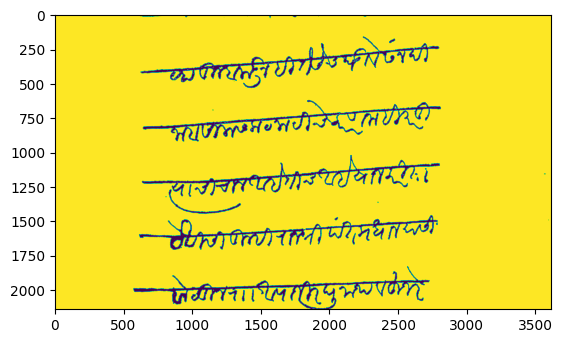

In [28]:
generate_caption('20.jpg')

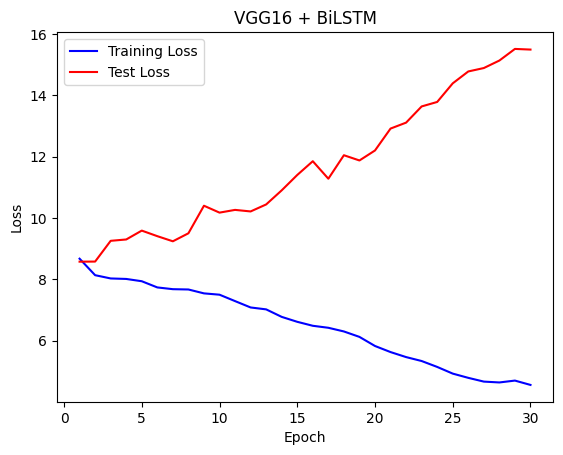

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# Get training and test loss histories
# training_loss = history.history['loss']
# test_loss = history.history['val_loss']
# print(training_loss)
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.title("VGG16 + BiLSTM")
plt.plot(epoch_count, training_loss, 'b')
plt.plot(epoch_count, test_loss, 'r')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(r"D:\COEP\BTech_Project\Code\new_dataset_code\VGG_RNN\train_val_loss_plot.png", format="png")
plt.show()

In [24]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    caption = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/202 [00:00<?, ?it/s]

BLEU-1: 0.007817
BLEU-2: 0.000000


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o